<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-II-Computer-Vision/04_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Transfer Learning

Now, let's consider what is Transfer learning?

The idea is quite simple. First, some big tech company, which has access to virtually
infinite amounts of data and computing power, develops and trains a huge model
for their own purpose. 

Next, once it is trained, its architecture and the corresponding trained weights (the pre-trained model) are released. Finally,
everyone else can use these weights as a starting point and fine-tune them
further for a different (but similar) purpose.

That’s transfer learning in a nutshell.

##Setup

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter7()
# This is needed to render the plots in this chapter
from plots.chapter7 import *

Finished!


In [3]:
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torchvision.models.alexnet import model_urls
try:
  from torchvision.models.utils import load_state_dict_from_url
except ImportError:
  from torch.hub import load_state_dict_from_url

from stepbystep.v3 import StepByStep
from data_generation.rps import download_rps

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
# content/gdrive/My Drive/Kaggle is the path where kaggle.json is  present in the Google Drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [ ]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset
kaggle datasets download -d sanikamal/rock-paper-scissors-dataset

unzip -qq rock-paper-scissors-dataset.zip
rm -rf rock-paper-scissors-dataset.zip

 97% 440M/452M [00:03<00:00, 123MB/s]
100% 452M/452M [00:04<00:00, 118MB/s]


## Data Preparation

The data preparation step will be a bit more demanding this time since we’ll be
standardizing the images.Besides, we can use the ImageFolder dataset now.

The Rock Paper Scissors dataset is organized like that:

```
rps/paper/paper01-000.png
rps/paper/paper01-001.png

rps/rock/rock01-000.png
rps/rock/rock01-001.png

rps/scissors/scissors01-000.png
rps/scissors/scissors01-001.png
```

The dataset is also perfectly balanced, with each sub-folder containing 840 images
of its particular class.

In [ ]:
ROOT_FOLDER = "Rock-Paper-Scissors"

Since we’re using a pre-trained model, we need to use the standardization
parameters used to train the original model. 

In other words, we need to use the
statistics of the original dataset used to train that model.

So, the data preparation step for the Rock Paper Scissors dataset looks like this now:

In [ ]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
composer = Compose([
  Resize(256),
  CenterCrop(224),
  ToTensor(),
  normalizer
])

train_data = ImageFolder(root=f"{ROOT_FOLDER}/train", transform=composer)
val_data = ImageFolder(root=f"{ROOT_FOLDER}/test", transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

##Pre-Trained Model

Let's start by creating an instance of AlexNet without loading its pre-trained
weights.

In [5]:
alex = alexnet(weights=False)
print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

###Adaptive Pooling

`AdaptiveAvgPool2d` is a special kind of pooling: Instead of requiring the kernel size
(and stride), it requires the desired output size. 

In other words, whatever the
image size it gets as input, it will return a tensor with the desired size.

It gives you the freedom to use images of different sizes as inputs.

Let’s verify it.

In [6]:
result1 = F.adaptive_avg_pool2d(torch.randn(16, 32, 32), output_size=(6, 6))
result2 = F.adaptive_avg_pool2d(torch.randn(16, 12, 12), output_size=(6, 6))

result1.shape, result2.shape

(torch.Size([16, 6, 6]), torch.Size([16, 6, 6]))

###Loading Weights

Let’s download the weights
from a given URL, which gives you the flexibility to use pre-trained weights from
wherever you want!

In [8]:
URL = model_urls["alexnet"]
URL

'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth'

In [9]:
state_dict = load_state_dict_from_url(URL, model_dir="pretrained", progress=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to pretrained/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [10]:
# let's load model
alex.load_state_dict(state_dict)

<All keys matched successfully>

###Model Freezing

Freezing the model means it won’t learn anymore; that is, its
parameters / weights will not be updated anymore.

What best characterizes a tensor representing a learnable parameter? It requires
gradients. 

So, if we’d like to make them stop learning anything, we need to change
exactly that:

In [11]:
def freeze_model(model):
  for parameter in model.parameters():
    parameter.requires_grad = False

freeze_model(alex)

If the model is frozen, how I am supposed to train it for my own
purpose?

We have to unfreeze a small part of the model or, better yet,
replace a small part of the model.

###Top of the Model

The "top" of the model is loosely defined as the last layer(s) of the model, usually
belonging to its classifier part. 

The featurizer part is usually left untouched since
we’re trying to leverage the model’s ability to generate features for us.

In [13]:
print(alex.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [14]:
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In our Rock Paper Scissors dataset, we have three classes. 

So, we need to replace the
output layer accordingly:

In [15]:
alex.classifier[6] = nn.Linear(in_features=4096, out_features=3)

In [16]:
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


Notice that the number of input features remains the same, since it still takes the
output from the hidden layer that precedes it. 

The new output layer requires
gradients by default, but we can double-check it:

In [17]:
for name, param in alex.named_parameters():
  if param.requires_grad == True:
    print(name)

classifier.6.weight
classifier.6.bias


## Model Training

The configuration part is short and straightforward: We use alex model, a loss
function, and an optimizer.

In [ ]:
torch.manual_seed(17)

multi_loss_fn = nn.CrossEntropyLoss(reduction="mean")
optimizer_alex = optim.Adam(alex.parameters(), lr=3e-4)

Once again, we use our StepByStep class to handle model training for us.

In [ ]:
sbs_cnn = StepByStep(model_cnn, multi_loss_fn, optimizer_cnn)
sbs_cnn.set_loaders(train_loader, val_loader)
sbs_cnn.train(10)

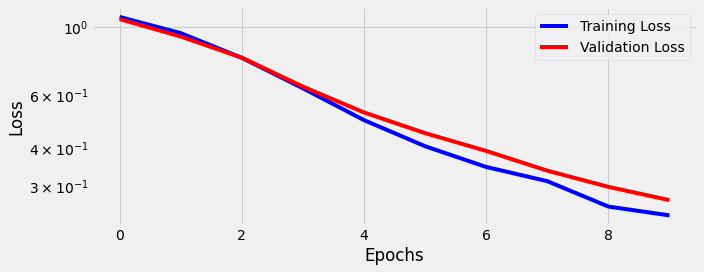

In [ ]:
fig = sbs_cnn.plot_losses()

We can also check the model’s accuracy for each class.

In [ ]:
StepByStep.loader_apply(val_loader, sbs_cnn.correct)

tensor([[ 92, 124],
        [119, 124],
        [116, 124]])